In [9]:
import numpy as np
import pandas as pd
from astropy.convolution import convolve,Gaussian2DKernel
from matplotlib.tri import Triangulation
import matplotlib.pyplot as plt
import os
import pickle

In [10]:
Inputs_folder = 'GRONINGEN/Inputs/'
# Results_folder = '/content/Groningen/Simulation_results/'
# Results_diffusion_folder = Results_folder + 'Reservoir_model/'
Results_mechanical_folder = 'TEMPORARY_FOLDER/Simulation results/Mechanical_model/'
# Results_seismicity_folder = Results_folder + 'Seismicity_model/'

In [11]:
def resample_to_month(data, start_time=0, fixed_date="2000-01-01"):
    """
    Resamples a time series array to the closest value to a full month and returns
    both the resampled data and the indices used for resampling.
    Args:
        data: A NumPy array representing the time series.
        start_time: Time in seconds from the fixed date (default: 0).
        fixed_date: The fixed date as a string in YYYY-MM-DD format (default: "2000-01-01").
    Returns:
        A tuple containing:
            - resampled_data: A pandas Series resampled to the closest month.
            - used_indices: A NumPy array containing the original data indices used 
                            for each resampled value.
    """
    
    # Convert start_time to datetime
    start_datetime = pd.to_datetime(fixed_date) + pd.Timedelta(seconds=start_time)
    # Convert data to timestamps relative to start_datetime
    timestamps = pd.to_timedelta(data, unit='s') + start_datetime
    series = pd.Series(data, index=timestamps)
    # Resample to 'M' (month) frequency with 'ffill'
    resampled = series.resample('M').ffill()
    # Iterate through resampled data to find original indices
    used_indices = np.zeros(len(resampled), dtype=int)
    
    for i, month in enumerate(resampled.index):
        # Find index of closest timestamp to month start
        closest_index = series.index.get_indexer([month], method='nearest')
        used_indices[i] = closest_index[0]
        
    return resampled, used_indices

# Example usage
times = np.load('GRONINGEN/Outputs - Diffusion model/List_t.p', allow_pickle=True)
pressures_list = 1e-6*np.load('GRONINGEN/Outputs - Diffusion model/pressure_list.npy', allow_pickle=True)
t_resampled, resampled_index = resample_to_month(times - times[0], start_time=times[0], fixed_date="1956-01-01")

t_decimal = 1956.0 + 9 + (times - times[0]) / 3.154e+7
t_decimal_resampled = 1956.0 + 9 + (t_resampled - t_resampled[0]) / 3.154e+7
np.save('TEMPORARY_FOLDER/Simulation results/Reservoir_model/time_decimal_resampled_mp.npy', t_decimal_resampled)

pressures_resampled = np.array(pressures_list)[resampled_index-1]
np.save('TEMPORARY_FOLDER/Simulation results/Reservoir_model/pressure_resampled_mp.npy', pressures_resampled)

/tmp/ipykernel_24550/800041392.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = series.resample('M').ffill()
/tmp/ipykernel_24550/800041392.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_decimal_resampled = 1956.0 + 9 + (t_resampled - t_resampled[0]) / 3.154e+7


In [12]:
# def find_closest_index(times, months):
#     closest_value = min(times, key=lambda x: abs(x - months))
#     return times.index(closest_value)

# month = 3600*24*365/12

# List_index = [0]

# times = np.load('GRONINGEN/Outputs - Diffusion model/List_t.p', allow_pickle=True)
# pressures_list = 1e-6*np.load('GRONINGEN/Outputs - Diffusion model/pressure_list.npy', allow_pickle=True)

# for i in range(1, int(12*(75-9))):
#     months = (9*12+i)*month
#     List_index.append(find_closest_index(times.tolist(), months))


# t_resampled = 1956 + times[List_index]/month/12
# pressures_resampled = pressures_list[List_index]
# np.save('TEMPORARY_FOLDER/Simulation results/Reservoir_model/time_decimal_resampled_mp.npy', t_resampled)
# np.save('TEMPORARY_FOLDER/Simulation results/Reservoir_model/pressure_resampled_mp.npy', pressures_resampled)

In [13]:
############################# Import the MORES model data from Oates et al., 2022 #############################
# Process the MORES data
folder_mores = 'TEMPORARY_FOLDER/External data/MoresModel/Simulation_results/'
t_decimal_MORES = np.load(folder_mores+'time_MORES.npy')
p_file = 'pressures_list.npy'
d_file = 'deformations_list.npy'
s_file = 'max_coulomb_stresses.npy'
#pressure
p_mesh_MORES = np.load(folder_mores+'MESH.npy')
p_MORES = np.load(folder_mores+p_file)
#deformation
d_mesh_MORES = np.load(folder_mores+'deformations_mesh.npy',allow_pickle=True)
d_MORES = np.load(folder_mores+d_file)
# stress
s_meshX_MORES = np.load(folder_mores+'stresses_meshX.npy',allow_pickle=True)
s_meshY_MORES = np.load(folder_mores+'stresses_meshY.npy',allow_pickle=True)
s_MORES = np.load(folder_mores+s_file,allow_pickle=True).item()['-10m']
Kernel = Gaussian2DKernel(6)

#################### Import the SP model data from Meyer et al., 2022, generated by MAc ##################
folder_sp = 'TEMPORARY_FOLDER/External data/SinglePhase/Simulation_results/'
p_file = 'pressures_list.npy'
d_file = 'deformations_list.npy'
s_file = 'max_coulomb_stresses.npy'

#pressure
p_mesh_sp = np.load(folder_sp+'MESH.npy')
p_sp = np.load(folder_sp+p_file)
#deformation
d_mesh_sp = np.load(folder_sp+'deformations_mesh.npy',allow_pickle=True)
d_sp = np.load(folder_sp+d_file)
# stress
s_meshX_sp = np.load(folder_sp+'stresses_meshX.npy',allow_pickle=True)
s_meshY_sp = np.load(folder_sp+'stresses_meshY.npy',allow_pickle=True)
s_sp = np.load(folder_sp+s_file,allow_pickle=True).item()['-10m']
Kernel = Gaussian2DKernel(6)
# time
t0_sp = 1956.0
t_decimal_sp = np.linspace(t0_sp,t0_sp+1/12*len(d_sp),len(d_sp))


##################### Import the MP model data from Ledevin et al., 2024 ########################################
# Import data from diffusion model
Results_diffusion_folder = 'TEMPORARY_FOLDER/Simulation results/Reservoir_model/'
t_decimal_mp = np.load(Results_diffusion_folder + 'time_decimal_resampled_mp.npy')
#pressure
p_mesh_mp = np.load('GRONINGEN/Outputs - Diffusion model/MESH.npy')/1e3
p_mp = np.load(Results_diffusion_folder+'pressure_resampled_mp.npy')
#deformation
d_mesh_mp = np.load(Results_mechanical_folder+'deformations_mesh.npy',allow_pickle=True)
d_mp = np.load(Results_mechanical_folder+'deformations_resampled_mp.npy',allow_pickle=True)
# stress
s_meshX_mp = np.load(Results_mechanical_folder+'stresses_meshX.npy',allow_pickle=True)
s_meshY_mp = np.load(Results_mechanical_folder+'stresses_meshY.npy',allow_pickle=True)
s_mp = np.load(Results_mechanical_folder+'max_coulomb_stresses_resampled_mp.npy')
Kernel = Gaussian2DKernel(6)

In [14]:
# Rebuild RES dictionary
folder_RES = os.path.join(Inputs_folder, 'RESDictionary_data/')
RES = {}
for filename in os.listdir(folder_RES):
    f = os.path.join(folder_RES, filename)
    if filename[-2:] == '.p':
        RES[filename[:-2]]=pickle.load(open(f,'rb'),encoding='latin1')

# Extract reservoir data
X, Y = RES['X'],RES['Y']#np.mgrid[np.min(RES['X']):np.max(RES['X']):500, np.min(RES['Y']):np.max(RES['Y']):500]
Thickness = RES['RES']['Thickness']#np.load(folder_name + 'ReservoirThickness.npy') / 1000 #dim change
Outline = RES['Outline'][['X','Y']]

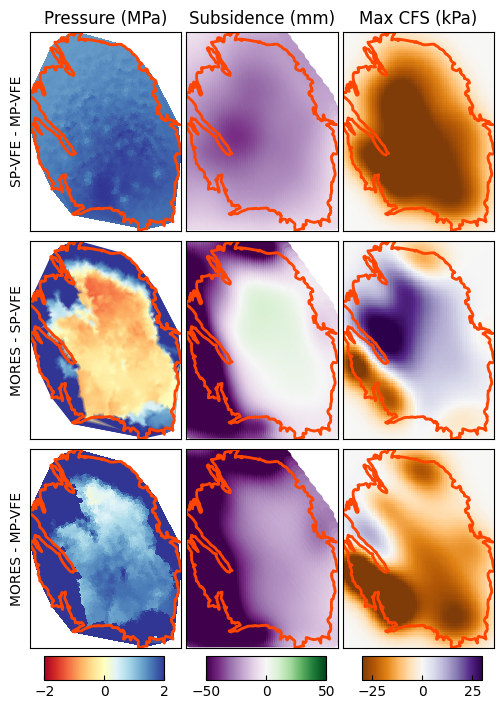

In [15]:
# Figure for the differences between models in pressure, subsidence and stress
#Arange the data in their original meshes
date = 2013
iii_MORES = np.argmin(abs(t_decimal_MORES-date))
iii_sp = np.argmin(abs(t_decimal_sp-date))
iii_mp = np.argmin(abs(t_decimal_mp-date))

pp_MORES_om = p_MORES[iii_MORES,:]/10
dd_MORES_om = d_MORES[iii_MORES,:]-d_MORES[0,:]
ss_MORES_om = convolve(s_MORES[:,:,iii_MORES],Kernel,nan_treatment='fill')

pp_sp_om = p_sp[iii_sp,:]
dd_sp_om = d_sp[iii_sp,:]-d_sp[0,:]
ss_sp_om = convolve(s_sp[:,:,iii_sp],Kernel,nan_treatment='fill')

pp_mp_om = p_mp[iii_mp,:]
dd_mp_om = d_mp[iii_mp,:]-d_mp[0,:]
ss_mp_om = convolve(s_mp[:,:,iii_mp],Kernel,nan_treatment='fill')

# match everything to the SP mesh
p_mesh = p_mesh_sp
d_mesh = d_mesh_sp
s_meshX = s_meshX_sp
s_meshY = s_meshY_sp

def find_closest_values(X1, Y1, Z1, X2, Y2, max_distance):
    Z2 = np.nan*np.zeros_like(X2)
    for i in range(X2.shape[0]):
        x2, y2 = X2[i], Y2[i]
        distances = np.sqrt((x2 - X1)**2 + (y2 - Y1)**2)
        min_distance = np.min(distances)
        if min_distance <= max_distance:
            min_index = np.argmin(distances)
            Z2[i] = Z1[min_index]
    return np.array(Z2)

max_distance = 2.5 # km tolerance

pp_MORES = find_closest_values(p_mesh_MORES[:,0], p_mesh_MORES[:,1], pp_MORES_om, p_mesh[:,0], p_mesh[:,1], max_distance)
dd_MORES = find_closest_values(d_mesh_MORES[0,:], d_mesh_MORES[1,:], dd_MORES_om, d_mesh[0,:], d_mesh[1,:], max_distance)
ss_MORES = ss_MORES_om

pp_sp = pp_sp_om
dd_sp = dd_sp_om
ss_sp = ss_sp_om

pp_mp = find_closest_values(p_mesh_mp[:,0], p_mesh_mp[:,1], pp_mp_om, p_mesh[:,0], p_mesh[:,1], max_distance)
dd_mp = find_closest_values(d_mesh_mp[0,:], d_mesh_mp[1,:], dd_mp_om, d_mesh[0,:], d_mesh[1,:], max_distance)
ss_mp = ss_mp_om

# Limits
deltaP = 2
deltaD = 50
deltaS = 30

# First set of subplots: map view snapshots
triang = Triangulation(p_mesh[:,0],p_mesh[:,1])
fig,axs = plt.subplots(3,3,figsize=(6, 8),gridspec_kw={'hspace': 0.05, 'wspace': 0.03})
jj=0
p1 = axs[jj,0].tripcolor(triang,pp_sp-pp_mp,cmap='RdYlBu',vmin=-deltaP,vmax=deltaP)
d1 = axs[jj,1].scatter(d_mesh[0,:],d_mesh[1,:],c=1e3*(dd_sp-dd_mp),cmap='PRGn',vmin=-deltaD,vmax=deltaD)
s1 = axs[jj,2].pcolormesh(s_meshX/1e3,s_meshY/1e3,1e3*(ss_sp-ss_mp),cmap='PuOr',vmin=-deltaS,vmax=deltaS)
jj=1
p1 = axs[jj,0].tripcolor(triang,pp_MORES-pp_sp,shading='gouraud',cmap='RdYlBu',vmin=-deltaP,vmax=deltaP)
d1 = axs[jj,1].scatter(d_mesh[0,:],d_mesh[1,:],c=1e3*(dd_MORES-dd_sp),cmap='PRGn',vmin=-deltaD,vmax=deltaD)
s1 = axs[jj,2].pcolormesh(s_meshX/1e3,s_meshY/1e3,1e3*(ss_MORES-ss_sp),cmap='PuOr',vmin=-deltaS,vmax=deltaS)
jj=2
p1 = axs[jj,0].tripcolor(triang,pp_MORES-pp_mp,cmap='RdYlBu',vmin=-deltaP,vmax=deltaP)
d1 = axs[jj,1].scatter(d_mesh[0,:],d_mesh[1,:],c=1e3*(dd_MORES-dd_mp),cmap='PRGn',vmin=-deltaD,vmax=deltaD)
s1 = axs[jj,2].pcolormesh(s_meshX/1e3,s_meshY/1e3,1e3*(ss_MORES-ss_mp),cmap='PuOr',vmin=-deltaS,vmax=deltaS)


axs[0,0].set_ylabel('SP-VFE - MP-VFE')
axs[1,0].set_ylabel('MORES - SP-VFE')
axs[2,0].set_ylabel('MORES - MP-VFE')

axs[0,0].set_title('Pressure (MPa)')
axs[0,1].set_title('Subsidence (mm)')
axs[0,2].set_title('Max CFS (kPa)')



for ii in range(axs.shape[0]):
    for jj in range(axs.shape[1]):
        ax = axs[ii,jj]
        ax.plot(Outline.X/1e3,Outline.Y/1e3,c='orangered',lw=2)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([Outline.X.min()/1e3,Outline.X.max()/1e3])
        ax.set_ylim([Outline.Y.min()/1e3,Outline.Y.max()/1e3])
        ax.set_aspect('equal')


# Add colorbars at the bottom of each column
cbar_ax_p = fig.add_axes([0.15, 0.07, 0.2, 0.03])  # Position of the colorbar
cbar_p = fig.colorbar(p1, cax=cbar_ax_p, orientation='horizontal')
cbar_p.ax.tick_params(axis='x', direction='in', which='both', labelleft=True, labelright=False)

cbar_ax_d = fig.add_axes([0.42, 0.07, 0.2, 0.03])  # Position of the colorbar
cbar_d = fig.colorbar(d1, cax=cbar_ax_d, orientation='horizontal')
cbar_d.ax.tick_params(axis='x', direction='in', which='both', labelleft=True, labelright=False)

cbar_ax_s = fig.add_axes([0.68, 0.07, 0.2, 0.03])  # Position of the colorbar
cbar_s = fig.colorbar(s1, cax=cbar_ax_s, orientation='horizontal')
cbar_s.ax.tick_params(axis='x', direction='in', which='both', labelleft=True, labelright=False)

# Annotate the panels
# panel_label(axs[0,0], '(A)',pos=(0.4,1.2))
# panel_label(axs[0,1], '(B)',pos=(0.4,1.2))
# panel_label(axs[0,2], '(C)',pos=(0.4,1.2))